# Bloqs

## Motivation
State-of-the-art compilations of teraquop-scale quantum algorithms are done by hand and the compilations are recorded
using a mixture of enumerated lists, dirac notation, and English prose in scientific articles.
To increase precision, accessibility, and automatability we introduce data structures for representing quantum
gates, subroutines, and programs manifested either as in-memory Python objects or serialized protocol buffers (protobufs).

Each quantum subroutine or operation (including non-unitary operations like qubit allocation) is represented by a class
which follows the `Bloq` abstract interface. We introduce a new name for this category of objects to avoid any implied constraints imposed by existing terms and to highlight that these form the building blocks of a quantum algorithm.
A minimal bloq is characterized by its name, input registers, and output registers.
Additional attributes and properties can be annotated on a bloq.

## Composition
Like any complex design process, quantum algorithms design and compilation can be made tractable by modularizing and abstracting
aspects of the problem. In Qualtran, bloqs can be composed and decomposed.
In composition, multiple bloqs are wired together in a directed acyclic graph (DAG)
where edges represent the flow of quantum data. 

In decomposition, a user can call the `decompose` method on a given bloq to get a graph 
of the subbloqs that make up the bloq. A bloq's decomposition defines the action of the bloq.

As an example, the modular exponentiation operation can be decomposed into $n$ modular multiplication operations. The composition
of those $n$ modular multiplication operations define the implementation of the modular exponentiation bloq.

In [ ]:
# Code for generating a skeleton

from qualtran.bloqs.factoring.mod_exp import ModExp
from qualtran.drawing.graphviz import SkeletonGraphDrawer

mod_exp = ModExp(exp_bitsize=3, x_bitsize=2048, base=9, mod=13*15)

s2 = SkeletonGraphDrawer(mod_exp.decompose_bloq(), label='\u00A0subbloq\u00A0')
s1 = SkeletonGraphDrawer(mod_exp, label='\u00A0bloq\u00A0')

display(s1.get_svg())
display(s2.get_svg())
with open('bloq-skeleton.svg', 'wb') as f:
    f.write(s1.get_svg_bytes())
with open('cbloq-skeleton.svg', 'wb') as f:
    f.write(s2.get_svg_bytes())

## Composition features

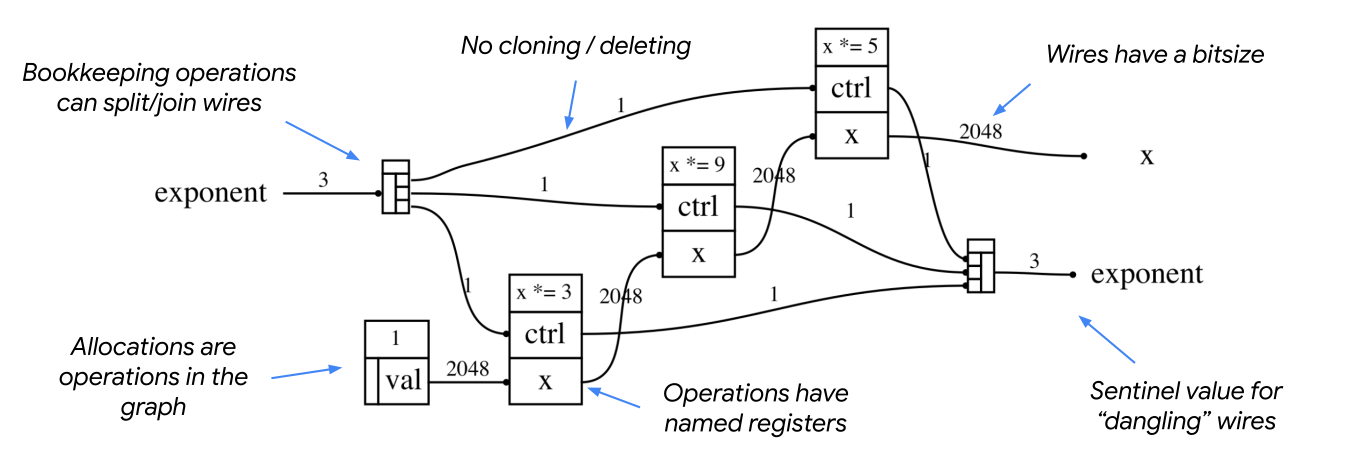

In the figure we can see the composition of six bloqs that shows notable features of the representation.

First, one can clearly observe the graph structure and trace the flow of quantum information. Each edge represents the flow
of quantum data from the output of one bloq to the input of a subsequent bloq. Each edge (sometimes refered to as a 'wire') has
a quantum data type which includes the bitsize of the quantum data. In contrast to some NISQ-focused software packages, this
lets us represent a large collection of qubits (in the example: 2048) with one object.

Of course, sometimes we need to operate on specific qubits. Bookeeping bloqs like `Split` and `Join` can take e.g. a 3-bit-wide wire and turn it into three 1-bit wires, as is done for the exponent variable in the figure.

We enforce the no-cloning and no-deletion theorems at the data structure
library by mandating that each register be connected to exactly one wire.
In the code for defining compositions, we don't manage the graph structure directly. Instead, the wire connection
points represent quantum variables that can be provided as inputs to bloqs and are returned as quantum outputs from a bloq. In this form,
no-clonong/no-deleting mandates that each quantum variable must be used exactly once. This is called linear logic, and the library enforces it at runtime. 
Failing to use a quantum variable would result in a graph with a dangling wire, and corresponds to deleting quantum information, which is not allowed. 
Using a quantum variable twice would result in a graph where a particular register has two outoing wires, and corresponds to cloning quantum information, which is similarly dissalowed.

You may object, noting that the figure shows dangling `exponent` and `x` wires on the far left and right of the figure. 
In the data structure, these edges are connected to specific sentinel values to mark them as inputs and outputs when viewing the composition as a quantum subroutine.
In a full quantum program, these edges would be connected to callers of the subroutine.

In contrast to some
quantum programming SDKs, we eschew the notion of an implicit pool of qubit addresses to act on. Instead, allocations and de-allocations
are bloqs in the composition. For interpretability and to remove a class of error related to mis-ordering qubits, each bloq register has a string name that is used to provide the input quantum variables.

In [ ]:
# The code for generating the figure:

from qualtran.drawing import show_bloq
from qualtran.bloqs.factoring.mod_exp import ModExp
from qualtran.bloqs.factoring.mod_mul import CtrlModMul

# Monkey patch in a shorter title.
CtrlModMul.short_name = lambda self: f'x *= {self.k}'

mod_exp = ModExp(exp_bitsize=3, x_bitsize=2048, base=9, mod=13*15)
show_bloq(mod_exp.decompose_bloq())

## Data Types

The qubit is the quantum analog of the classical bit and is often taken as the elementary element of quantum information. A qubit has two states: 0 and 1 -- but unlike classical bit, it can exist in superposition of these two states. Extending the analogy, we can use a collection of qubits to encode data like integers and real numbers. 

Qualtran offers first-class support for quantum data types. When each bloq declares its signature, it must report not only the arity and names of its inputs and outputs, but also its quantum data type. Each data type follows an abstract interface that requires that the encoding to (qu)bits is specified. The number of qubits is always available to aid in resource estimation. 

Whereas classical programming languages have a finite collection of atomic types based on the machine architecture like `int32` or `float64`, the quantum data types in Qualtran are dependent types and depend on attributes. For example, the `QInt` type takes a `bitsize` parameter that lets the bloq author specify an arbitrary bit width of a given register. This is particularly important for resource estimation for quantum computers where we anticipate being extremely limited by qubit count and the overhead of using a larger bitsize type when we know our values to be in a particular range is unacceptable.

The library contains data types for unsigned integers, one's and two's complement signed integers, Montgomery integers, and fixed point reals. Additional types can be introduced by implementing the `QDType` abstract interface. We also provide a "qubit" type for individual bit manipulation and an "any" type if the bloq's signature does not depend on the encoded information. Data flowing from one bloq to another must have matching quantum data types or the library will raise an error. 

A balance between expressivity and structure always needs to be struck when designing abstractions. Qualtran does not support sum (union) or product (struct) types; and by extension does not support quantum strings or quantum lists. This is to ensure we can make meaningful statements about the costs and resource requirements of quantum algorithms given the constraints of not-too-distant-future quantum architectures. 

Qualtran has special support for fixed-size multidimensional arrays of quantum data. For example, a bloq that selects a register from $m$ input registers and swaps it into the first position can define its signature as one control register and an array of `m` `QInt` registers.